# Welcome to Cancellation Predictor
---

The dataframe will be divided based on hotel type. My plan is to train model based on City hotel, than check how well will the model work for the other type.

## EDA Checklist:

* Arrivals per month (for each year)
* Average lead_time per year
* Cancellations % per month 
* Cancellations % per year
* Impact of repeated guest on cancellation ratio
* Channel impact on cancellations
* Company impact on cancellations
* Correlation analysis




In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set()
sns.set_palette(sns.color_palette('Set1'))
sns.set_style("whitegrid")

import numpy as np

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("hotel_bookings.csv")

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

In [3]:
print("Dataframe contains " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns.")

Dataframe contains 119390 rows and 32 columns.


In [4]:
df.hotel.unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

### Define crucial variables and functions:
- dataframe for model enegeriing 
- total number of reservations
- total number of cancellations

In [5]:
#Dataframe of City Hotel's data
city_df = df[df['hotel'] == 'City Hotel'].reset_index(drop=True)
#Total number of reservation (cancellation + successuful)
total_reservation = city_df.shape[0]
#Total number of cancelled bookings
total_cancelled = city_df[city_df['is_canceled'] == 1].shape[0]
#Months list
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

total_cancelled/total_reservation*100

41.72696331778646

In [6]:
city_df.isnull().sum()

hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
country                              24
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              8131
company                           75641


### Arrivals (successful reservations) per day (for each year)

In [7]:
arrivals_df = pd.DataFrame(city_df[city_df['is_canceled']==0].groupby(['arrival_date_month','arrival_date_year'])['hotel'].count().unstack(level=1))
arrivals_df.index = pd.CategoricalIndex(arrivals_df.index, categories=months, ordered=True)
arrivals_df = arrivals_df.sort_index().rename_axis(None)

Text(0, 0.5, 'Total succesful arrivals')

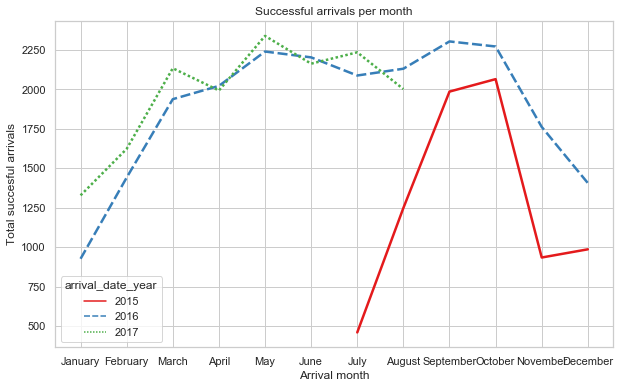

In [8]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=arrivals_df, linewidth=2.5)
ax.set_title('Successful arrivals per month')
ax.set_xlabel('Arrival month')
ax.set_ylabel('Total succesful arrivals')

Text(0, 0.5, 'Total arrivals')

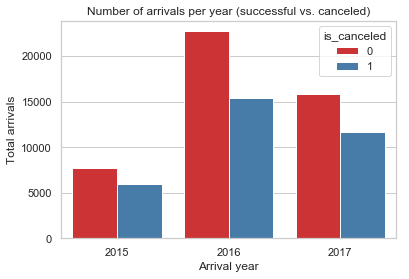

In [9]:
ax=sns.countplot(x='arrival_date_year', data=city_df, hue='is_canceled')
ax.set_title('Number of arrivals per year (successful vs. canceled)')
ax.set_xlabel('Arrival year')
ax.set_ylabel('Total arrivals')

Text(0, 0.5, 'Total arrivals')

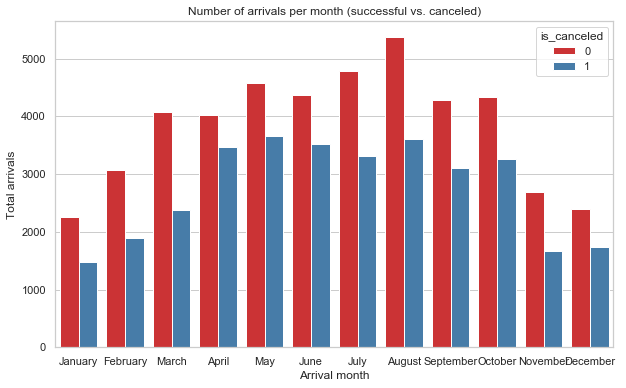

In [10]:
plt.figure(figsize=(10,6))
ax=sns.countplot(x='arrival_date_month', data=city_df, hue='is_canceled',order=months)
ax.set_title('Number of arrivals per month (successful vs. canceled)')
ax.set_xlabel('Arrival month')
ax.set_ylabel('Total arrivals')

### Lead time vs. cancelations

In [11]:
#Creating dataframe of lead time median across years and months
lead_time = pd.DataFrame(city_df.groupby(['arrival_date_month','arrival_date_year','is_canceled'])['lead_time'].median().unstack(level=1))
lead_time = lead_time.reset_index().set_index('arrival_date_month')
lead_time.index = pd.CategoricalIndex(lead_time.index, categories=months, ordered=True)
lead_time = lead_time.sort_index().rename_axis(None)

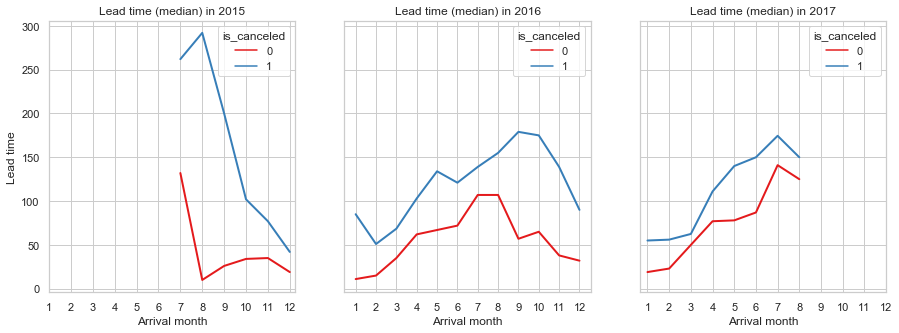

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, squeeze=True)

for year, ax in [(2015,0),(2016,1),(2017,2)]:
    sns.lineplot(ax=axes[ax], y=year, x=lead_time.index,data=lead_time, hue='is_canceled',linewidth=2)
    axes[ax].set_title('Lead time (median) in ' + str(year))
    axes[ax].set_xticks(np.arange(0,12))
    axes[ax].set_xticklabels(np.arange(1,13))
    axes[ax].set_xlabel('Arrival month')
    axes[ax].set_ylabel('Lead time')


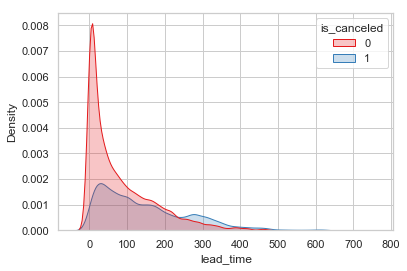

In [13]:
sns.kdeplot(data=df, x='lead_time', hue='is_canceled', shade = True)

Text(0, 0.5, 'Customer type')

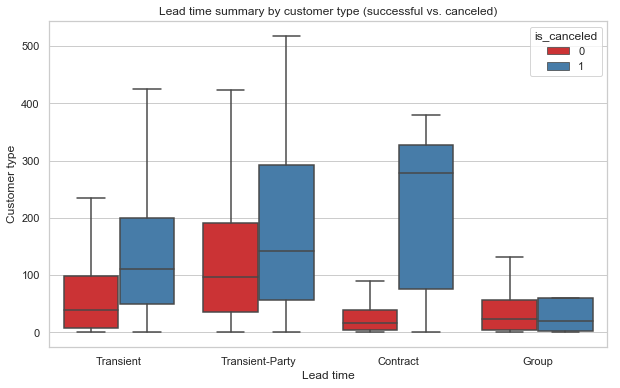

In [14]:
plt.figure(figsize=(10,6))
ax=sns.boxplot(x='customer_type',y='lead_time',hue='is_canceled',data=city_df, showfliers = False)
ax.set_title('Lead time summary by customer type (successful vs. canceled)')
ax.set_xlabel('Lead time')
ax.set_ylabel('Customer type')

Text(0, 0.5, 'Arrival year')

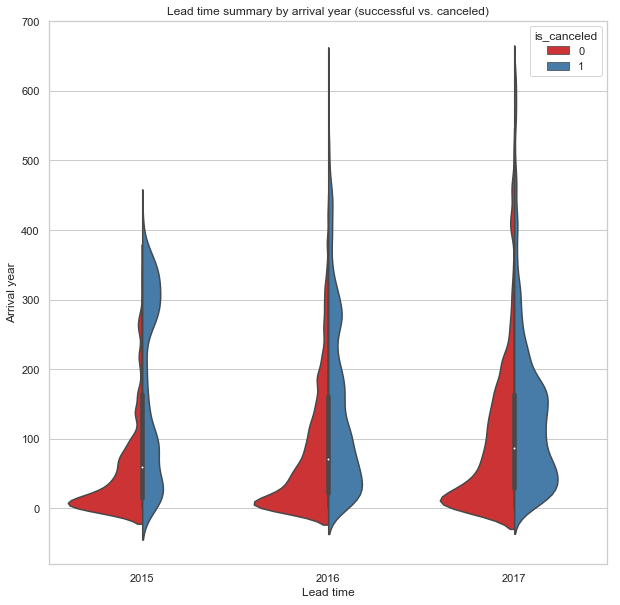

In [15]:
plt.figure(figsize=(10,10))
ax=sns.violinplot(x='arrival_date_year', y ='lead_time', hue="is_canceled", data=city_df, split=True)
ax.set_title('Lead time summary by arrival year (successful vs. canceled)')
ax.set_xlabel('Lead time')
ax.set_ylabel('Arrival year')

### Cancelations ratio summary

In [16]:
#Creating dataframes for future usage
all_bookings = pd.DataFrame(city_df.groupby(['arrival_date_month','arrival_date_year'])['hotel'].count().unstack(level=1))
cancelations = pd.DataFrame(city_df[city_df['is_canceled']==1].groupby(['arrival_date_month','arrival_date_year'])['hotel'].count().unstack(level=1))
cancelation_ratios = cancelations/all_bookings * 100
cancelation_ratios.index = pd.CategoricalIndex(cancelation_ratios.index, categories=months, ordered=True)
cancelation_ratios = cancelation_ratios.sort_index().rename_axis(None)

Text(0, 0.5, 'Cancelations [%]')

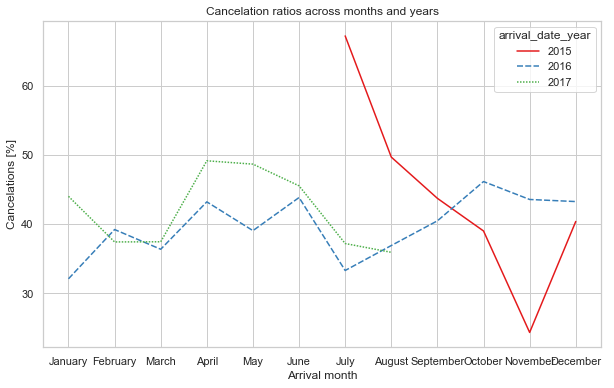

In [17]:
plt.figure(figsize=(10,6))
ax=sns.lineplot(data=cancelation_ratios)
ax.set_title('Cancelation ratios across months and years')
ax.set_xlabel('Arrival month')
ax.set_ylabel('Cancelations [%]')

Text(0, 0.5, 'Cancelation ratio [%]')

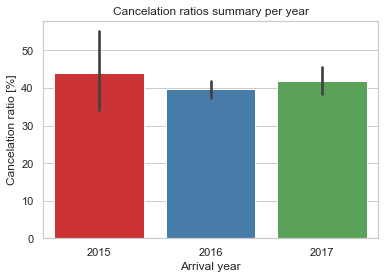

In [18]:
ax=sns.barplot(data=cancelation_ratios)
ax.set_title('Cancelation ratios summary per year')
ax.set_xlabel('Arrival year')
ax.set_ylabel('Cancelation ratio [%]')

## Cancelations & repeated guests

Text(0, 0.5, 'Number of reservations')

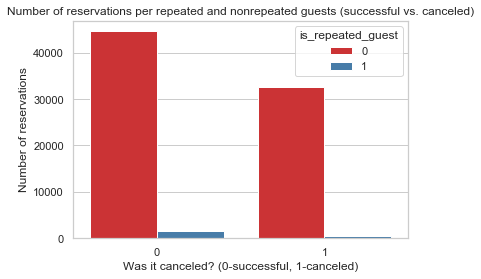

In [19]:
ax=sns.countplot(x="is_canceled", hue='is_repeated_guest', data=city_df)
ax.set_title('Number of reservations per repeated and nonrepeated guests (successful vs. canceled)')
ax.set_xlabel('Was it canceled? (0-successful, 1-canceled)')
ax.set_ylabel('Number of reservations')

In [20]:
all_bookings_repeated = pd.DataFrame(city_df.groupby(['arrival_date_month','is_repeated_guest'])['hotel'].count())
cancelations_repeated = pd.DataFrame(city_df[city_df['is_canceled']==1].groupby(['arrival_date_month','is_repeated_guest'])['hotel'].count())

#Defying ratio dataframe
cancelations_is_repeated_ratio = cancelations_repeated/all_bookings_repeated * 100
cancelations_is_repeated_ratio.reset_index(inplace=True)
cancelations_is_repeated_ratio.set_index('arrival_date_month', inplace=True)
cancelations_is_repeated_ratio.index = pd.CategoricalIndex(cancelations_is_repeated_ratio.index, categories=months, ordered=True)
cancelations_is_repeated_ratio = cancelations_is_repeated_ratio.sort_index().rename_axis(None)

### Cancelation ratio for non repeated and repeated guests
% of reservation canceled for both categories: non repeated and repeated guests

Text(0, 0.5, 'Cancelation ratio [%]')

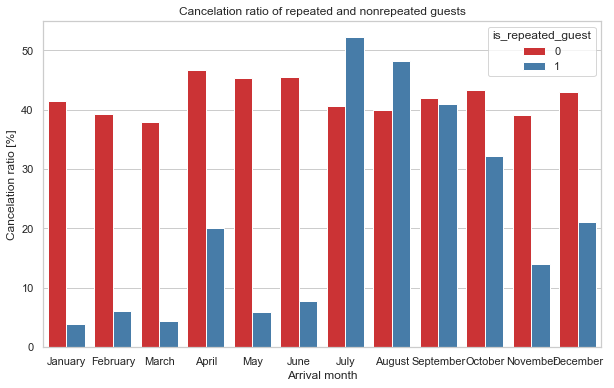

In [21]:
plt.figure(figsize=(10,6))
ax=sns.barplot(data=cancelations_is_repeated_ratio, x=cancelations_is_repeated_ratio.index, y='hotel', hue='is_repeated_guest')
ax.set_title('Cancelation ratio of repeated and nonrepeated guests')
ax.set_xlabel('Arrival month')
ax.set_ylabel('Cancelation ratio [%]')

### Share of each reservation type (repeated vs non repeated guest) in general cancelations

In [22]:
#Setting up dataframes
all_bookings = pd.DataFrame(city_df.groupby(['arrival_date_month'])['is_canceled'].count())
cancelations_repeated['cancelation_ratio'] = cancelations_repeated['hotel']/all_bookings['is_canceled']*100

#Index fixing
cancelations_repeated.reset_index(inplace=True)
cancelations_repeated.set_index('arrival_date_month', inplace=True)
cancelations_repeated.index = pd.CategoricalIndex(cancelations_repeated.index, categories=months, ordered=True)
cancelations_repeated = cancelations_repeated.sort_index().rename_axis(None)

Text(0, 0.5, 'Cancelation ratio [%]')

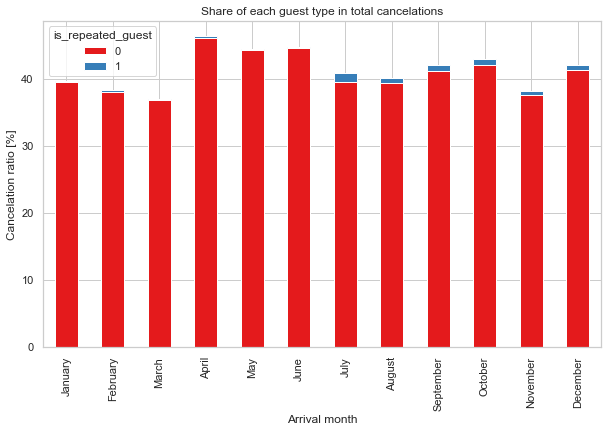

In [23]:
ax=cancelations_repeated.pivot(columns='is_repeated_guest',values='cancelation_ratio').plot(kind='bar',stacked=True, figsize=(10,6))
ax.set_title('Share of each guest type in total cancelations')
ax.set_xlabel('Arrival month')
ax.set_ylabel('Cancelation ratio [%]')